### Import Data and Necessary Packages

In [51]:
## Read in CSV of all HS players

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
from scipy.stats import gaussian_kde, percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
hs_data = pd.read_csv("/Users/jamesjoyce/Documents/GitHub/frame-score/hs_data.csv")

combine_data = pd.read_excel("/Users/jamesjoyce/Documents/GitHub/frame-score/combine_data.xlsx")

hs_data.shape
hs_data.columns

TimeoutError: [Errno 60] Operation timed out

### Merging and Cleaning Data

In [4]:
### Preview of Data
print(combine_data.head())

## Pulling only NFL Combine Data from 2013 and Up to Minimize incorrect merges
combine_data = combine_data[combine_data['NICYr'] >= 2013]

      Player_Name  NICYr Pro_Pos NIC_Pos NIC_Group        College      HT  \
1     Dan Skipper   2017       T      OL        OL       Arkansas  6095.0   
4         Joe Alt   2024       T       T        OL     Notre Dame  6085.0   
5   Kolton Miller   2018       T      OL        OL           UCLA  6085.0   
7   Trenton Brown   2015       T      OL        OL        Florida  6084.0   
9  Luke Marquardt   2013       T      OL        OL  Azusa Pacific  6084.0   

    HT_in     WT    Hand  ...  Pos2   PB  PB_T  PB_O  PB_A   AP  AP_T  AP_1  \
1  81.625  309.0  1048.0  ...   NaN  0.0   0.0   0.0   0.0  0.0   0.0   0.0   
4  80.625  321.0     NaN  ...   NaN  NaN   NaN   NaN   NaN  NaN   NaN   NaN   
5  80.625  309.0  1068.0  ...   NaN  0.0   0.0   0.0   0.0  0.0   0.0   0.0   
7  80.500  355.0  1078.0  ...   NaN  0.0   0.0   0.0   0.0  0.0   0.0   0.0   
9  80.500  315.0  1028.0  ...   NaN  0.0   0.0   0.0   0.0  0.0   0.0   0.0   

   AP_2  PlayerID3  
1   0.0    45721.0  
4   NaN        NaN  

In [ ]:
#Cleaning Positioning Data and adding in Position Groups of BIGS, MIDS, SKILLS based on their Position

position_map = {
    'qb':"QB",
    'cb':'DB',
    'wr':'WR',
    'rb':'RB',
    'ol':'LB',
    's_':'DB',
    'at':'ATH',
    'dt':'DL',
    'og':'OL',
    'dl':'DL',
    'ot':'OL',
    'il':'LB',
    'ce':'OL',
    'ti':'TE',
    'te':'TE' 
    
}

position_group_map = {
    "DL": "BIGS",
    "OL": "BIGS",
    "OLB": "BIGS",
    "RB": "MIDS",
    "LB": "MIDS",
    "SP": "MIDS",
    "QB": "MIDS",
    "TE": "MIDS",
    "FB": "MIDS",
    "DB": "SKILLS",
    "ATH": "SKILLS",
    "WR": "SKILLS",
    
}


hs_data["Positions"] = hs_data['Position'].map(position_map)

hs_data["Position_Group"] = hs_data['Positions'].map(position_group_map)

### Merging Datasets and Selecting Columns for Model

#### Breakdown of Players by Position Groups BIGS, MIDS, SKILLS

In [17]:
# Breakdown of Data for each player based on Position Groups
hs_data.head()
hs_data.groupby('Position_Group').apply(lambda x: x.notna().sum())


,Source_File,Name,Link,Height,Weight,Dash40,Shuttle20,Vertical,Position,SPARQ,Power_Throw,Positions,Position_Group
Position_Group,,,,,,,,,,,,,
BIGS,1127,1127,1127,1127,1127,1007,1074,1088,1127,168,0,1127,1127
MIDS,1552,1552,1552,1552,1552,1318,1464,1493,1552,0,0,1552,1552
SKILLS,1329,1329,1329,1329,1329,1143,1256,1282,1329,393,185,1329,1329


In [ ]:

# Merging Datasets with inner-join, so only matches in both datasets are included 
new_combined_data = pd.merge(combine_data,hs_data, left_on='Player_Name', right_on= 'Name', how= 'inner')

# Removing Special Teams Players
new_combined_data = new_combined_data[new_combined_data['NIC_Group'].isin(['DB','DL','LB','OL','QB','RB','TE','WO'])]
    

Selecting Columns for Analysis

In [20]:
final_test_data =new_combined_data[['Name','Positions','Position_Group',
        'HT_in', 'WT', 'Hand_in', 'Arm_in',
       'Wing_in', 'Height', 'Weight']]

### Using PyCaret for exploratory model selection

#### Exploratory Data Analysis & Reviewing Merged Dataset

In [21]:
final_test_data.info()
final_test_data = final_test_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            610 non-null    object 
 1   Positions       610 non-null    object 
 2   Position_Group  610 non-null    object 
 3   HT_in           610 non-null    float64
 4   WT              610 non-null    float64
 5   Hand_in         610 non-null    float64
 6   Arm_in          610 non-null    float64
 7   Wing_in         608 non-null    float64
 8   Height          610 non-null    int64  
 9   Weight          610 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 47.8+ KB


In [22]:
final_test_data.value_counts('Positions')

Positions
DB     106
DL     101
OL      83
RB      66
WR      63
ATH     60
LB      59
QB      47
TE      23
Name: count, dtype: int64

In [23]:
final_test_data.value_counts('Position_Group')

Position_Group
SKILLS    229
MIDS      195
BIGS      184
Name: count, dtype: int64

In [24]:
# Renaming Columns for Standardizing Features for Model
df = final_test_data.rename(columns={
    'WT': 'College_Weight', 
    'Weight': 'HS_Weight',
    'Arm_in': 'Arm_Length',
    'Hand_in': 'Hand_Size',
    'Wing_in': 'Wing_Length'
})

# Converting our Position & Position Group Features to Categorical for the Regression Model
df['Position_Group'] = df['Position_Group'].astype('category')
df['Positions'] = df['Positions'].astype('category')


arm_dict = df.groupby('Position_Group')['Arm_Length'].mean().to_dict()
print(arm_dict)

#df['Arm_Length'] = df['Arm_Length'].fillna(df['Position_Group'].map(arm_dict))

hand_dict = df.groupby('Position_Group')['Hand_Size'].mean().to_dict()
print(hand_dict)

#df["Hand_Size"] = df['Hand_Size'].fillna(df['Position_Group'].map(hand_dict))

wing_dict = df.groupby('Position_Group')['Wing_Length'].mean().to_dict()
print(wing_dict)




{'BIGS': 33.38070652173913, 'MIDS': 31.777717948717946, 'SKILLS': 31.693427947598252}
{'BIGS': 9.897690217391304, 'MIDS': 9.521410256410256, 'SKILLS': 9.280873362445416}
{'BIGS': 80.13627717391304, 'MIDS': 76.34633333333333, 'SKILLS': 75.97958515283842}


/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/3865015495.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arm_dict = df.groupby('Position_Group')['Arm_Length'].mean().to_dict()
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/3865015495.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hand_dict = df.groupby('Position_Group')['Hand_Size'].mean().to_dict()
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/3865015495.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

In [25]:
features = ['HT_in', 'College_Weight', 'Hand_Size', 'Arm_Length','Wing_Length', 'Height', 'HS_Weight']
df.groupby('Position_Group').describe()

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/2219058601.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Position_Group').describe()


HT_in                                                  \
                count       mean       std     min       25%      50%   
Position_Group                                                          
BIGS            184.0  75.741848  1.779110  68.000  74.71875  75.6875   
MIDS            195.0  73.137179  2.630626  65.250  71.25000  73.0000   
SKILLS          229.0  72.427948  2.004619  67.125  71.00000  72.3750   

                                College_Weight              ... Height        \
                    75%     max          count        mean  ...    75%   max   
Position_Group                                              ...                
BIGS            76.8750  80.625          184.0  294.233696  ...   77.0  80.0   
MIDS            74.9375  79.375          195.0  228.548718  ...   75.0  80.0   
SKILLS          73.7500  78.125          229.0  205.157205  ...   74.0  77.0   

               HS_Weight                                                     \
                   count        mean        std    min    25%    50%    75%   
Position_Group                                                                
BIGS               184.0  280.994565  33.818464  195.0  260.0  282.0  302.5   
MIDS               195.0  208.512821  18.928340  160.0  195.0  208.0  221.0   
SKILLS             229.0  186.816594  16.965173  152.0  175.0  183.0  196.0   

                       
                  max  
Position_Group         
BIGS            370.0  
MIDS            272.0  
SKILLS          260.0  

[3 rows x 56 columns]

### Handling Potential Outliers

Wrote this function to flag potential outliers in the dataset or potentially flag mismatched merged data based on common names (John Smith, etc.). Given past research in the space that body proportions show linear associations, this should improve outcome by flagging potentially incorrect data. I used the Position Group Means on Measurements to Identify measurements that showed significant difference (like Height)

flag_outliers_iqr:
- Calculates Interquartile Range (IQR)
- Calculates upper and lower bounds for this column based on that value
    - Lower = Q1 - 1.5 * IQR
    - Upper = Q3 + 1.5 * IQR
- Runs the IQR for each Position Group to Calculate any potential players that fall outside these bounds
- Returns a DataFrame with these potential outliers

##### Potential Outliers Based on College Weight

In [26]:
def flag_outliers_iqr(df, group_col, value_col):
    def flag(group):
        if group[value_col].isnull().all():
            return pd.Series([False]*len(group), index=group.index)
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return (group[value_col] < lower) | (group[value_col] > upper)

    df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)
    return df

weights_flagged = flag_outliers_iqr(df, "Position_Group", "College_Weight")
weights_flagged[weights_flagged['is_outlier']]


/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1422905229.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)


,Name,Positions,Position_Group,HT_in,College_Weight,Hand_Size,Arm_Length,Wing_Length,Height,HS_Weight,is_outlier
15,Jordan Davis,TE,MIDS,78.375,341.0,10.750,34.000,81.125,77,257,True
62,Stephen Sullivan,WR,SKILLS,76.875,248.0,10.125,35.375,85.000,77,230,True
128,Jared Pinkney,WR,SKILLS,76.000,257.0,10.500,32.875,79.000,77,224,True
139,Joshua Perry,DB,SKILLS,75.750,254.0,10.000,33.875,81.500,75,184,True
159,Mike Williams,DL,BIGS,75.625,218.0,9.380,33.380,79.880,74,305,True
176,Lecitus Smith,TE,MIDS,75.250,314.0,9.625,31.875,78.750,75,253,True
180,Brian Allen,OL,BIGS,75.125,215.0,10.000,34.000,78.500,73,287,True
186,Alvin Bailey,ATH,SKILLS,75.125,312.0,9.375,34.750,80.875,71,175,True
223,Derrick Henry,ATH,SKILLS,74.625,247.0,8.750,33.000,80.750,75,243,True
230,Dylan Parham,QB,MIDS,74.625,311.0,10.250,33.125,78.875,77,205,True


##### Removing or Updating Values
- To ensure data quality, I went through the list of players who have been identified and manually checked their values against their ESPN 300 and NFL draft profiles to ensure a correct match

- Ran into 2 Scenarios:
    - Correct Matches, but Players transitioned to a new position group(WR --> TE, TE --> OL, etc.)
    - Incorrect Matches due to Common Name

- If match was correct, but player switched position groups I updated it
- If match was incorrect I removed the player entirely

In [ ]:
#Updated Values
updates = {
    62:  {'Positions': 'TE', 'Position_Group': 'MIDS'},
    128: {'Positions': 'TE', 'Position_Group': 'MIDS'},
    176: {'Positions': 'OL', 'Position_Group': 'BIGS'},
    223: {'Positions': 'RB', 'Position_Group': 'MIDS'},
    253: {'Positions': 'TE', 'Position_Group': 'MIDS'},
    360: {'Positions': 'DL', 'Position_Group': 'BIGS'},
}

# Inputting the Updated Values into our dataset
for idx, vals in updates.items():
    df.at[idx, 'Positions'] = vals['Positions']
    df.at[idx, 'Position_Group'] = vals['Position_Group']


In [29]:
#Checking Updates to Confirm Changes
df[df.index.isin([62,128,176,223,253,360])]

,Name,Positions,Position_Group,HT_in,College_Weight,Hand_Size,Arm_Length,Wing_Length,Height,HS_Weight,is_outlier
62,Stephen Sullivan,TE,MIDS,76.875,248.0,10.125,35.375,85.000,77,230,True
128,Jared Pinkney,TE,MIDS,76.000,257.0,10.500,32.875,79.000,77,224,True
176,Lecitus Smith,OL,BIGS,75.250,314.0,9.625,31.875,78.750,75,253,True
223,Derrick Henry,RB,MIDS,74.625,247.0,8.750,33.000,80.750,75,243,True
253,A.C. Leonard,TE,MIDS,74.375,252.0,9.250,33.000,78.125,75,232,True
360,Kalia Davis,DL,BIGS,73.000,302.0,9.500,33.625,80.000,74,223,True


In [30]:
## Removing Incorrect Matches
clean_df = df[~df.index.isin([15,139,159,180,186,230,281,296,353,372,497,512,523,548,600])]



##### Potential Ouliers Based on Arm Length

Arm Length showed no incorrect matches

In [31]:
weights_flagged = flag_outliers_iqr(clean_df, "Position_Group", "Arm_Length")
weights_flagged[weights_flagged['is_outlier']]

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1422905229.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1422905229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)


,Name,Positions,Position_Group,HT_in,College_Weight,Hand_Size,Arm_Length,Wing_Length,Height,HS_Weight,is_outlier
62,Stephen Sullivan,TE,MIDS,76.875,248.0,10.125,35.375,85.00,77,230,True
172,Christian Miller,LB,MIDS,75.375,247.0,9.750,35.125,82.25,76,212,True
595,Ryan Switzer,WR,SKILLS,68.500,181.0,9.250,28.000,68.00,69,170,True


##### Potential Outlier Based on Combine Recorded Height

No incorrect matches

In [20]:
weights_flagged = flag_outliers_iqr(clean_df, "Position_Group", "HT_in")
weights_flagged[weights_flagged['is_outlier']]

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_3856/1422905229.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_3856/1422905229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)


,Name,Positions,Position_Group,HT_in,College_Weight,Hand_Size,Arm_Length,Wing_Length,Height,HS_Weight,is_outlier
0,Kolton Miller,OL,BIGS,80.625,309.0,10.75,34.125,82.50,80,281,True
1,Zach Banner,OL,BIGS,80.375,353.0,10.75,34.880,82.63,80,305,True
21,Darren Waller,DB,SKILLS,78.125,238.0,9.00,33.250,80.50,76,203,True
609,J.J. Taylor,RB,MIDS,65.250,185.0,8.50,28.750,71.25,65,160,True


##### Potential Outliers Based on Hand Size

One incorrect match that was removed

In [21]:
weights_flagged = flag_outliers_iqr(clean_df, "Position_Group", "Hand_Size")
weights_flagged[weights_flagged['is_outlier']][['Positions','Name','Hand_Size','HS_Weight','College_Weight']]

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_3856/1422905229.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_3856/1422905229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)


,Positions,Name,Hand_Size,HS_Weight,College_Weight
8,DL,DeForest Buckner,11.750,230,291.0
34,OL,Adam Bisnowaty,11.380,277,304.0
113,DL,LaBryan Ray,8.500,270,283.0
123,WR,Juwan Johnson,10.500,212,230.0
153,DL,Terry Beckner Jr.,8.625,298,296.0
221,OL,Isaiah Wynn,8.500,274,313.0
229,DL,Jordan Jenkins,11.250,245,259.0
243,WR,Kenny Lawler,10.500,175,203.0
255,OL,Matt Jones,8.625,314,231.0
314,DL,Gerald Willis III,8.500,275,302.0


In [22]:
## Removing Incorrect Matches
clean_df = clean_df[~clean_df.index.isin([255])]


##### Potential Outliers Based on Wingspan

No incorrect Matches

In [32]:
weights_flagged = flag_outliers_iqr(clean_df, "Position_Group", "Wing_Length")
#weights_flagged.loc[weights_flagged['is_outlier'],['Positions','Name','Wing_Length','HS_Weight','College_Weight']]
weights_flagged[weights_flagged['is_outlier']][['Positions','Name','Wing_Length','HS_Weight','College_Weight']]

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1422905229.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1422905229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_outlier"] = df.groupby(group_col).apply(flag).reset_index(level=0, drop=True)


,Positions,Name,Wing_Length,HS_Weight,College_Weight
6,QB,Tyree Jackson,83.750,200,249.0
13,OL,Jaryd Jones-Smith,88.500,313,317.0
47,LB,Terrell Lewis,83.375,206,262.0
62,TE,Stephen Sullivan,85.000,230,248.0
74,LB,Jeremiah Moon,83.625,210,249.0
397,DL,Elijah Qualls,74.000,282,313.0
411,DB,Shaquem Griffin,66.500,183,227.0
595,WR,Ryan Switzer,68.000,170,181.0
604,ATH,Isaiah McKenzie,68.250,160,173.0


In [33]:
# Final Dataset size after first round of Outlier Removals
clean_df.shape

(593, 11)

In [43]:
# Converted Clean_df Position Group and Positions to Categorical
clean_df['Position_Group'] = clean_df['Position_Group'].astype('category')
clean_df['Positions'] = clean_df['Positions'].astype('category')
print(clean_df.head())

              Name Positions Position_Group   HT_in  College_Weight  \
0    Kolton Miller        OL           BIGS  80.625           309.0   
1      Zach Banner        OL           BIGS  80.375           353.0   
2      Cole Kelley        QB           MIDS  79.375           249.0   
3  Colby Parkinson        TE           MIDS  79.250           252.0   
4     Jelani Woods        QB           MIDS  79.125           253.0   

   Hand_Size  Arm_Length  Wing_Length  Height  HS_Weight  is_outlier  
0     10.750      34.125       82.500      80        281       False  
1     10.750      34.880       82.630      80        305       False  
2      9.875      33.750       81.250      79        246       False  
3      9.625      33.250       78.625      79        228       False  
4      9.500      34.500       82.000      79        230       False  


/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1291432443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Position_Group'] = clean_df['Position_Group'].astype('category')
/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/1291432443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Positions'] = clean_df['Positions'].astype('category')


### Plot Distributions
- Now I plotted box plots for each variable by position to see if any more significant outliers exist after using the IQR to visually see any potential outliers



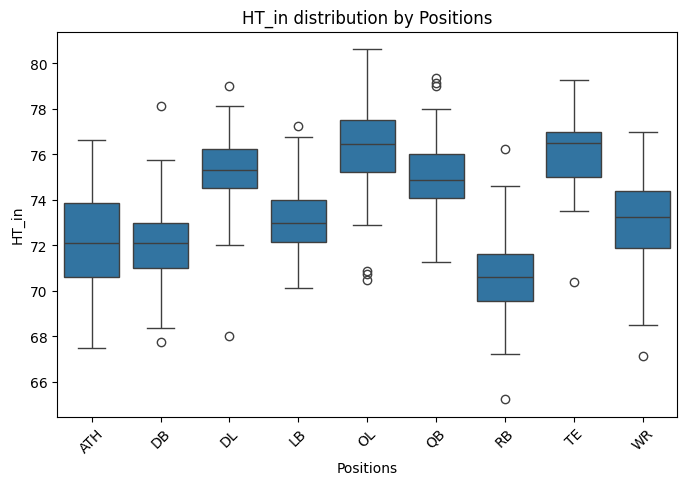

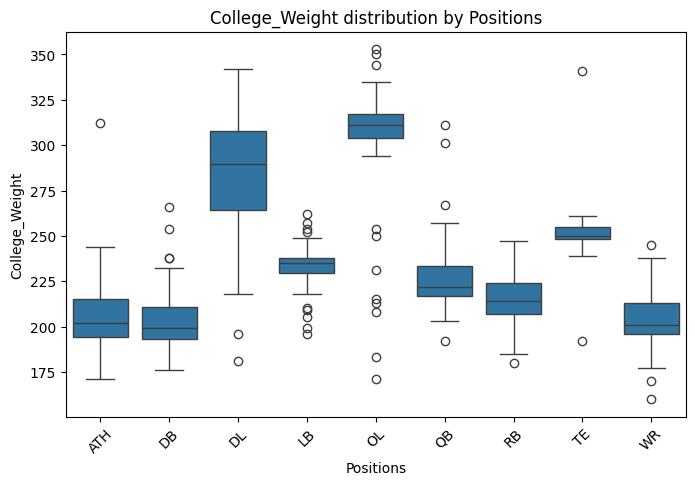

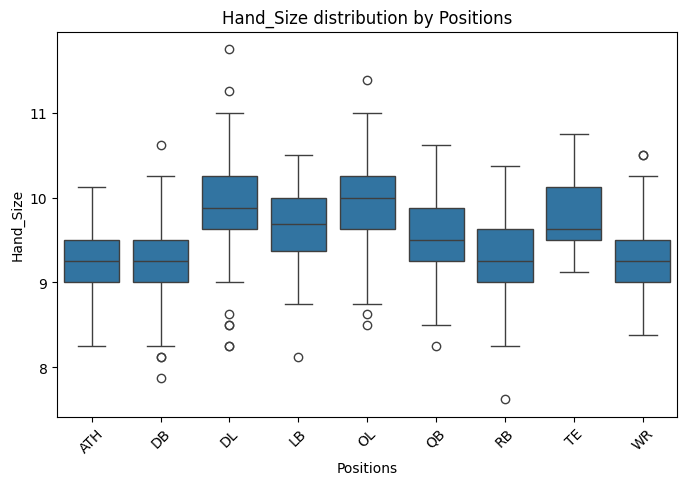

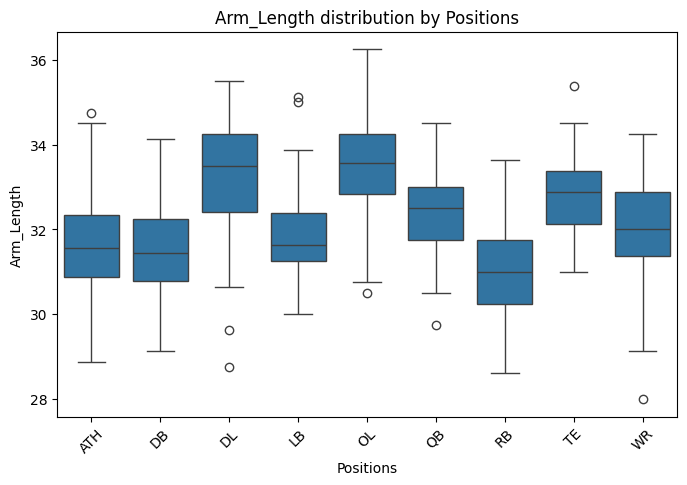

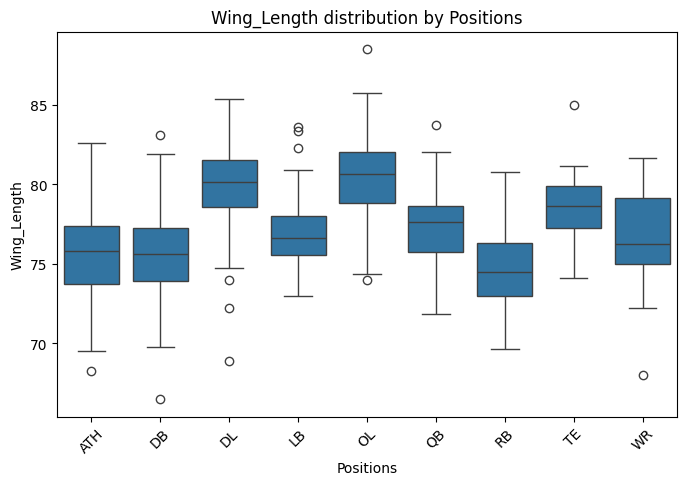

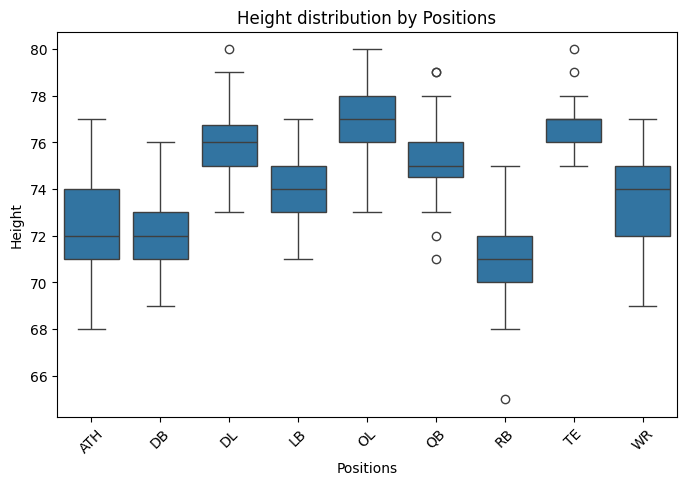

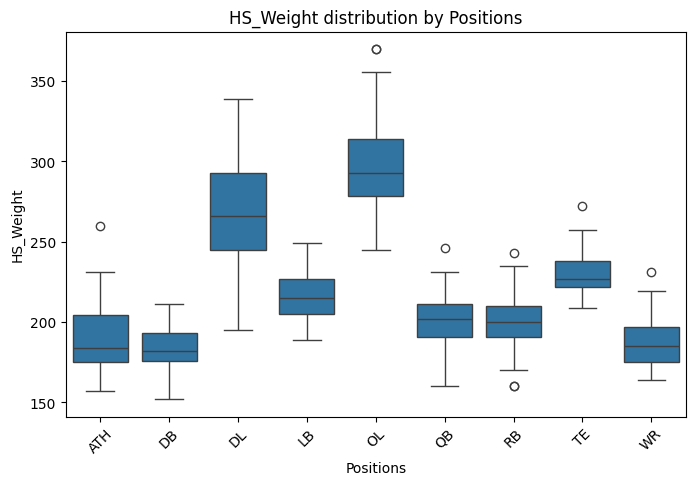

In [35]:
numeric_cols = clean_df.select_dtypes(include='number').columns
group_col = 'Positions'

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=group_col, y=col)
    plt.title(f"{col} distribution by {group_col}")
    plt.xticks(rotation=45)
    plt.show()

- As you can see, there were a few values that weren't captured by the first round of data cleaning as shown by the college weight distribution graphs
- Now, we'll remove again based on outliers outside the same bounds as last time, but now for the updated datasets

In [36]:
# Example: df is your DataFrame
group_col = "Positions"
value_col = "College_Weight"

def remove_outliers_iqr(df, group_col, value_col):
    def filter_group(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
    
    return df.groupby(group_col, group_keys=False).apply(filter_group)

df_clean = remove_outliers_iqr(clean_df, group_col, value_col)


/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/4163672580.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_col, group_keys=False).apply(filter_group)


#### Rerun Boxplot Visualizations

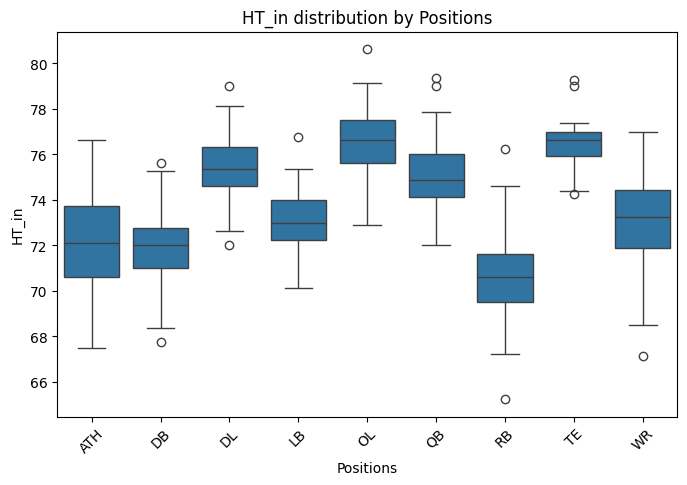

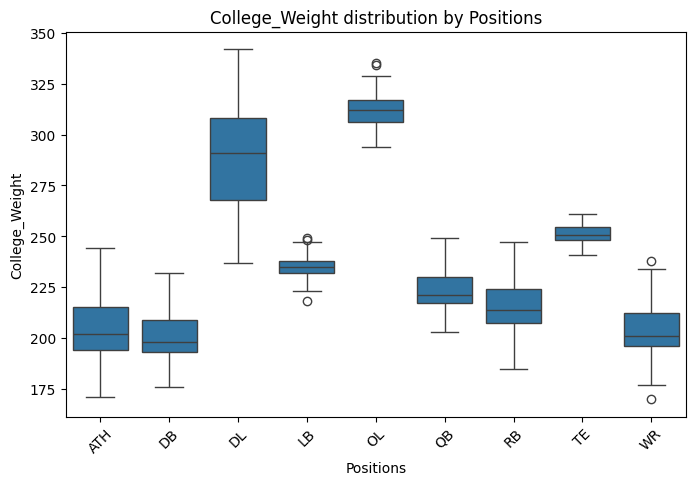

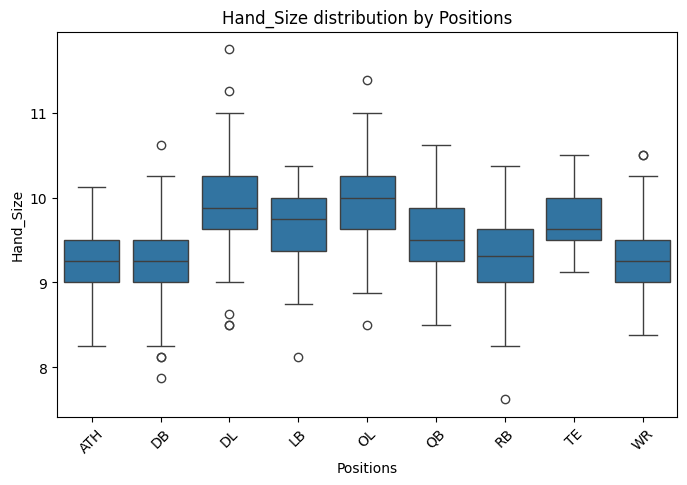

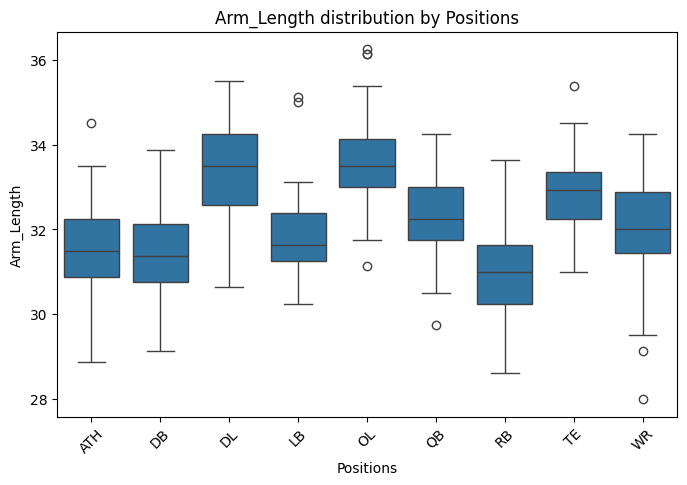

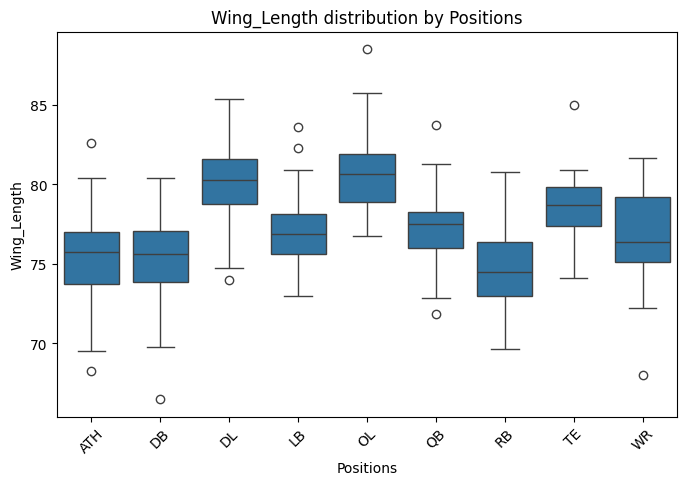

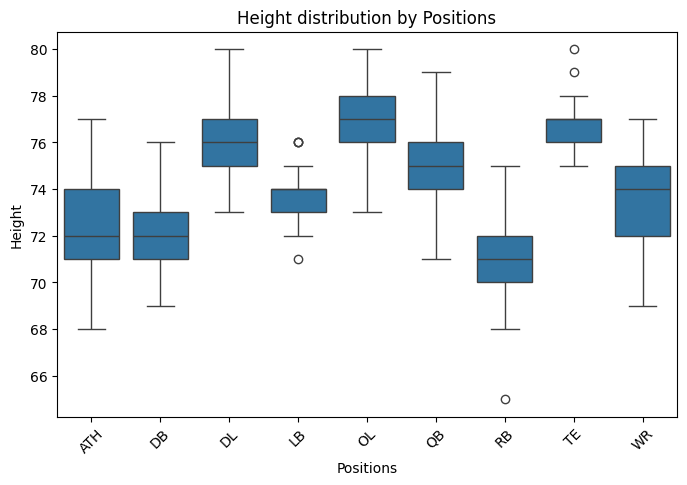

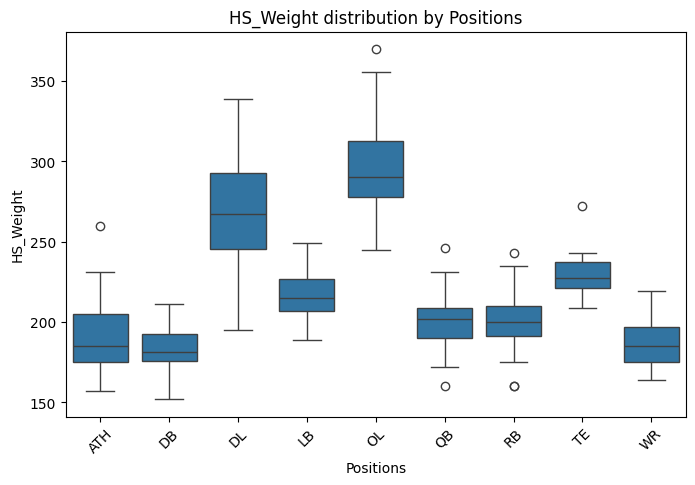

In [37]:

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_clean, x=group_col, y=col)
    plt.title(f"{col} distribution by {group_col}")
    plt.xticks(rotation=45)
    plt.show()

In [38]:
df_clean[df_clean.index.isin([62,128,176,223,253,360])]

,Name,Positions,Position_Group,HT_in,College_Weight,Hand_Size,Arm_Length,Wing_Length,Height,HS_Weight,is_outlier
360,Kalia Davis,DL,BIGS,73.000,302.0,9.500,33.625,80.000,74,223,False
176,Lecitus Smith,OL,BIGS,75.250,314.0,9.625,31.875,78.750,75,253,False
223,Derrick Henry,RB,MIDS,74.625,247.0,8.750,33.000,80.750,75,243,False
62,Stephen Sullivan,TE,MIDS,76.875,248.0,10.125,35.375,85.000,77,230,True
128,Jared Pinkney,TE,MIDS,76.000,257.0,10.500,32.875,79.000,77,224,False
253,A.C. Leonard,TE,MIDS,74.375,252.0,9.250,33.000,78.125,75,232,False


### Bayesian Ridge Linear Regression Model
- Chosen over Standard Multiple Linear Regession for the following Reasons
    - (Fill in After Landing)


#### Overview of Steps taken
1. Converted Positions Variable to Categorical
2. Created Interaction Terms for Height and Position
    - This is because their Position is extremely dependent on training plan and overall plan
3. Ran Test Train Split on the data
    - Train the model on a subset of the entire dataset so you can evaluate the model on unseen data
    - This is standard practice within DS
    - Is also stratified based on Position to Ensure datasets are balanced 
4. Preprocess the data for the model
    - One Hot Encoding: Making Categorical Variables suitable for linear regression
    - Standard Scaler: Scaling to Z-score (Normalizing it is another term for this)
5. Fit the Model on training data
6. Predict the Model on Testing Data
7. Evaluate Model based on Results with Residuals
    - Calculated RMSE & R2
8. Calculated Feature Importance to Show what Features were most significant in prediction
9. Created a Dataframe to show actual, prediction, and 95% confidence interval

In [50]:
# Ensure Positions is categorical
df_clean['Positions'] = df_clean['Positions'].astype('category')

# Create interaction terms: HS_Weight × 1{Position==g}
#     - This Allows the model to take in affect of the Position on a players potential Weight

pos_levels = df_clean['Positions'].cat.categories
for g in pos_levels:
    df_clean[f'HS_Weight_x_{g}'] = df_clean['HS_Weight'] * (df_clean['Positions'] == g).astype(int)

# Features / target
# Just Creating the Correct Naming Conventions to feed into the model
interaction_terms = [f'HS_Weight_x_{g}' for g in pos_levels]

# Numeric Features
base_numeric = ['Height', 'HS_Weight', 'Hand_Size', 'Wing_Length']

# Categorical Features
cat_features = ['Positions']

# Putting the Features Together
num_features = base_numeric + interaction_terms
features = num_features + cat_features

# Seperating Features and Independent Variable
X = df_clean[features]
y = df_clean['College_Weight']

# Test Train Split to evaluate model on unseen data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Preprocess the Model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features),
    ],
    remainder='drop'
)

bayesian_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('bayes_ridge', BayesianRidge())
])

# ---------- 4) Fit ----------
bayesian_pipeline.fit(X_train, y_train)

# ---------- 5) Evaluate ----------
y_pred, y_std = bayesian_pipeline.predict(X_test, return_std=True)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2: {r2:.3f}")

# ---------- 6) Feature Importance ----------
def get_feature_names_from_ct(ct):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            try:
                n = trans.get_feature_names_out(cols)
            except TypeError:
                n = trans.get_feature_names_out()
        else:
            n = np.array(cols, dtype=object)
        names.extend(n)
    return np.array(names, dtype=object)

encoded_features = get_feature_names_from_ct(bayesian_pipeline.named_steps['preprocess'])
coefficients = bayesian_pipeline.named_steps['bayes_ridge'].coef_

feature_importance = (
    pd.DataFrame({'Feature': encoded_features, 'Coefficient': coefficients})
      .reindex(np.argsort(-np.abs(coefficients)))
      .reset_index(drop=True)
)
print(feature_importance)

# ---------- 7) Prediction Intervals ----------
# (1.7 * std is your choice; ~95% would be ~1.96 for normal)
lower_bound = y_pred - 1.7 * y_std
upper_bound = y_pred + 1.7 * y_std

interval_df = pd.DataFrame({
    'Predicted': y_pred,
    'Lower Bound (≈95%)': lower_bound,
    'Upper Bound (≈95%)': upper_bound,
    'Actual': y_test.reset_index(drop=True)
})
print(interval_df)


Test RMSE: 8.96
Test R^2: 0.947
            Feature  Coefficient
0      Positions_OL   123.647572
1      Positions_LB    49.238926
2      Positions_TE    37.228256
3      Positions_DL    29.384993
4      Positions_QB    24.224156
5         HS_Weight    19.388638
6    HS_Weight_x_OL   -19.002486
7      Positions_WR   -17.207614
8      Positions_DB   -15.048699
9    HS_Weight_x_DL    12.015315
10   HS_Weight_x_DB    10.864404
11   HS_Weight_x_WR     9.304672
12   HS_Weight_x_RB     6.757692
13   HS_Weight_x_LB    -5.264951
14  HS_Weight_x_ATH     5.092525
15      Wing_Length     2.665192
16     Positions_RB     2.170839
17           Height     1.655012
18        Hand_Size     0.400665
19   HS_Weight_x_QB     0.358995
20   HS_Weight_x_TE     0.025426
      Predicted  Lower Bound (≈95%)  Upper Bound (≈95%)  Actual
0    261.975123          237.161023          286.789223   254.0
1    204.312895          179.927733          228.698057   209.0
2    194.808168          170.185993          219.4

#### Distribution of Residuals
- This is the result of the residuals based on both the Training Data and Testing Data
- Results
    - Showed Promising Results with 25% to 75% having prediction intervals within 10 for everyone but DL and 15 for DL 
- Skill Positions had tighter intervals which checks out wiht intuition

In [46]:
residuals = y_test.reset_index(drop=True) - y_pred

# Get positions from X_test (assuming Position is in the original dataset)
positions = X_test.reset_index(drop=True)['Positions']

# Combine into DataFrame
residuals_df = pd.DataFrame({
    'Residual': residuals,
    'Positions': positions
})


residuals_df.groupby('Positions').describe()

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_21749/2717886614.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  residuals_df.groupby('Positions').describe()


Residual                                                       \
             count      mean        std        min        25%       50%   
Positions                                                                 
ATH            8.0 -2.918398   5.103054 -11.714493  -5.290072 -2.973314   
DB            30.0 -0.426105   7.156948 -17.379407  -5.029449  0.092696   
DL            20.0 -2.673331  14.470579 -29.538844 -11.689903 -4.356423   
LB             9.0  2.510415   6.463886  -4.540201  -1.593558  1.775067   
OL             5.0 -2.136206   7.444206 -12.930922  -6.004891  0.297288   
QB            10.0  0.721392   7.438034  -9.859410  -3.452063 -0.387908   
RB            10.0  0.292469  11.344850 -12.963843  -9.632763  1.675499   
TE             4.0  7.244340   3.707194   3.040068   4.672171  7.739397   
WR            18.0 -3.479693   5.538937 -12.627128  -6.918677 -3.406969   

                                 
                 75%        max  
Positions                        
ATH         1.500813   2.764657  
DB          4.300277  13.348930  
DL          8.679043  19.292580  
LB          3.726472  16.248802  
OL          1.803315   6.154178  
QB          5.894412  12.288156  
RB          4.910706  23.310669  
TE         10.311566  10.458497  
WR         -1.090506   9.946009

In [ ]:
# Predict on training data
y_train_pred = bayesian_pipeline.predict(X_train)


residuals = y_train.reset_index(drop=True) - y_train_pred

# Get positions from X_test (assuming Position is in the original dataset)
positions = X_train.reset_index(drop=True)['Positions']

# Combine into DataFrame
residuals_df = pd.DataFrame({
    'Residual': residuals,
    'Positions': positions
})


residuals_df.groupby('Positions').describe()

/var/folders/ld/0cyh6sf12j74yc5vgj6bw8ch0000gn/T/ipykernel_3856/4224296620.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  residuals_df.groupby('Positions').describe()


Residual                                                       \
             count      mean        std        min        25%       50%   
Positions                                                                 
ATH           49.0 -0.451031   9.643420 -22.591406  -7.209632 -1.541285   
DB            72.0 -0.019771   9.194818 -14.677026  -5.591166 -1.502662   
DL            79.0  0.035185  18.795463 -44.420181 -10.955548 -1.048421   
LB            40.0  0.116441   5.914039 -13.819448  -3.339978 -0.023433   
OL            68.0  0.172003   7.999386 -23.913872  -5.595962 -0.022521   
QB            31.0  0.073917   8.112536 -16.332703  -5.014561 -0.295850   
RB            56.0  0.003667   7.341794 -20.221191  -4.673673  0.328536   
TE            18.0  0.195640   6.469394 -11.750133  -6.148033  2.009684   
WR            41.0 -0.039700  10.293877 -19.200370  -5.626615 -0.238809   

                                 
                 75%        max  
Positions                        
ATH         6.058225  22.806236  
DB          1.880346  34.815395  
DL         12.528931  60.980974  
LB          3.520020  13.824196  
OL          6.453848  14.902524  
QB          2.145164  20.269877  
RB          4.588790  23.302113  
TE          4.969618   8.849034  
WR          5.871720  36.990801